## Analysis packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer # sklearn 클래스 변경으로 인해 대체
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_columns', 100)

## Load the Data

In [2]:
trainset = pd.read_csv('C:\\Users\\신태경\\KaggleStudy\\PortoSeguro\\train.csv')
testset = pd.read_csv('C:\\Users\\신태경\\KaggleStudy\\PortoSeguro\\test.csv')

## Few quick observations
We can make few observations based on the data description in the competition:  
  
몇 개의 그룹이 정의되어 있으며 해당 그룹들의 이름에는 패턴(ind, reg, car, calc)이 포함됩니다.  
The ind indicates most probably individual,  
reg is probably registration, car is self-explanatory,  
calc suggests a calculated field;  
* bin은 binary features를 뜻합니다.  
* cat은 categorical feature을 나타냅니다.  
* bin이나 cat이 없는 feature은 real number(실수)나 integers(정수)를 의미합니다.  
* missing value는 -1로 표시됩니다.  
* prediction의 주체는 target column입니다. 이는 보험 청구가 접수 됐는지를 나타냅니다.  
* id는 input이 되는 서수(순서가 있는)입니다.

In [3]:
trainset.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


cat은 categorical values인 것을 학인할 수 있습니다.   
정수는 0부터 n까지 범위가 있습니다.  
bin은 이진 분류(0 or 1)입니다.  
  
 얼마나 많은 row column이 있는지 확인해 보겠습니다.

In [4]:
print("Train dataset (rows, cols):", trainset.shape, "\nTest dataset(rows, cols):", testset.shape)

Train dataset (rows, cols): (595212, 59) 
Test dataset(rows, cols): (892816, 58)


training dataset에는 59개, testing dataset에는 58개의 컬럼이 있습니다. 이는 target이 없기 때문일 것입니다. 모든 것이 괜찮은지 확인하기 위해 두 데이터셋의 컬럼들을 비교해 보겠습니다.

In [5]:
print("Columns is train and not in test dataset:", set(trainset.columns)-set(testset.columns))

Columns is train and not in test dataset: {'target'}


set은 중복을 허용하지 않으며 이런 특성을 이용해 trainset.columns - testset.columns를 수행한다.

## Introduction of metadata  
데이터의 조작을 쉽게 하기 위해 약간의 메타 정보를 트레인셋의 변수(variable)에 조합할 것입니다.  
이는 분석이나 검사, 또는 모델링을 위한 다양한 타입의 피처를 쉽게 선택하게 해줍니다.  
우리는 car, ind, reg, calc 같은 피처의 타입을 카테고리 필드로 사용합니다.  
metadata가 사용할 요소들 입니다.  
* use: input, ID, target  
* type: nominal, interval, ordinal, binary  
* preserve: True of False  
* dataType: int, float char  
* category: ind, reg, car, calc

In [14]:
data = []
for feature in trainset.columns:
    # Defining the role
    if feature == 'target':
        use = 'target'
    elif feature == 'id':
        use = 'id'
    else:
        use = 'input'
         
    # Defining the type
    if 'bin' in feature or feature == 'target':
        type = 'binary'
    elif 'cat' in feature or feature == 'id':
        type = 'categorical'
    elif trainset[feature].dtype == float or isinstance(trainset[feature].dtype, float):
        type = 'real'
    elif trainset[feature].dtype == 'int64': # int로 하면 특정한 feature들의 분류가 제대로 되지 않음.
        type = 'integer'
        
    # id만 빼고 모든 변수를 True로 초기화해 저장합니다.
    preserve = True
    if feature == 'id':
        preserve = False
    
    # Defining the data type 
    dtype = trainset[feature].dtype
    
    category = 'none'
    # Defining the category
    if 'ind' in feature:
        category = 'individual'
    elif 'reg' in feature:
        category = 'registration'
    elif 'car' in feature:
        category = 'car'
    elif 'calc' in feature:
        category = 'calculated'
        
    # 모든 변수의 메타데이터를 담고 있는 딕셔너리를 생성합니다.
    feature_dictionary = {
    'varname': feature,
    'use': use,
    'type': type,
    'preserve': preserve,
    'dtype': dtype,
    'category' : category
    }
    data.append(feature_dictionary)
    
metadata = pd.DataFrame(data, columns=['varname', 'use', 'type', 'preserve', 'dtype', 'category'])
metadata.set_index('varname', inplace=True)
metadata

,use,type,preserve,dtype,category
varname,,,,,
id,id,categorical,False,int64,none
target,target,binary,True,int64,none
ps_ind_01,input,integer,True,int64,individual
ps_ind_02_cat,input,categorical,True,int64,individual
ps_ind_03,input,integer,True,int64,individual
ps_ind_04_cat,input,categorical,True,int64,individual
ps_ind_05_cat,input,categorical,True,int64,individual
ps_ind_06_bin,input,binary,True,int64,individual
ps_ind_07_bin,input,binary,True,int64,individual


모든 categorical value를 추출해 보겠습니다.

In [15]:
# pd_ind_03과 같은 변수들의 type 컬럼이 categorycal로 잡혀서 metadata 조건을 int에서 int 64로 변경함.
metadata[(metadata.type == 'categorical') & (metadata.preserve)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

얼마나 많은 카테고리가 있는지 모든 feature를 살펴보겠습니다.

In [16]:
pd.DataFrame({'count' : metadata.groupby(['category'])['category'].size()}).reset_index()

,category,count
0,calculated,20
1,car,16
2,individual,18
3,none,2
4,registration,3


feature의 갯수:  
    
* calculated 20  
* car 16  
* individual 18  
* registration 3  
모든 feature를 탐색해서 얼마나 많은 use와 고유값이 있는지 알아보겠습니다.

In [28]:
metadata.groupby(['use', 'type'])['use'].size()

use     type       
id      categorical     1
input   binary         17
        categorical    14
        integer        16
        real           10
target  binary          1
Name: use, dtype: int64

In [ ]:
pd.DataFrame({'count' : metadata.groupby(['use', 'type'])['use'].size()}).reset_index()

* 명목 데이터는 하나가 있습니다.(id)  
* binary value: 20  
* 실수(혹은 소수): 21  
* categorical: 16  
이들은 모두 input으로 사용될 것입니다.  
binary인 target 데이터도 하나 있습니다.

## Data analysis and statistics

### Target variable

In [32]:
x = trainset['target'].value_counts().index.values
x

array([0, 1], dtype=int64)

In [41]:
y = trainset['target'].value_counts().values
y

array([573518,  21694], dtype=int64)

<Figure size 432x288 with 0 Axes>

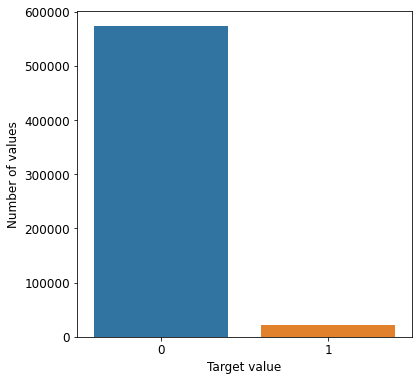

In [43]:
plt.figure()
fig, ax = plt.subplots(figsize=(6, 6))
x = trainset['target'].value_counts().index.values
y = trainset['target'].value_counts().values # values는 array 타입으로 바꿔줌
# bar plot
# tetget의 평균을 기준으로 내림차순 정렬
sns.barplot(ax=ax, x=x, y=y)
plt.ylabel('Number of values', fontsize=12)
plt.xlabel('Target value', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

In [63]:
target_0 = trainset[trainset['target'] == 0]['target'].value_counts().values
target_1 = trainset[trainset['target'] == 1]['target'].value_counts().values
total_target = target_0 + target_1
print('Percentage of target=1:', 100*(target_1/total_target))

Percentage of target=1: [3.64475179]


3.6% 정도의 target data가 1입니다. 이는 training dataset이 매우 불균형한 것을 의미합니다. 따라서 target=0을 기준으로 undersample을 할 수 있고, target=1을 기준으로 oversample을 할 수 있습니다. dataset이 크기 때문에 target=0을 기준으로 undersampling을 진행하겠습니다.

### Real features

In [64]:
variable = metadata[(metadata.type == 'real') & (metadata.preserve)].index
trainset[variable].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


In [67]:
(pow(trainset['ps_car_12']*10, 2)).head(10)

0    16.00
1    10.00
2    10.00
3    14.00
4     9.99
5    19.89
6    10.00
7    19.98
8    16.00
9    20.00
Name: ps_car_12, dtype: float64

missing value가 있는 피처들  
`ps_reg_03, ps_car_12, ps_car_14` (-1값을 가짐)

Registration features  
`ps_reg_01, ps_reg_02`는 분모가 10인 분수입니다. (0.1, 0.2, 0.3)

Car features  
`ps_car_12`는 추정치라고 할 수 있는데 자연수의 제곱근의 형태이며 10으로 나누어 졌습니다.  
'ps_car_15'는 자연수의 제곱근입니다. 이들을 pairplot을 통해 표현해 보겠습니다.

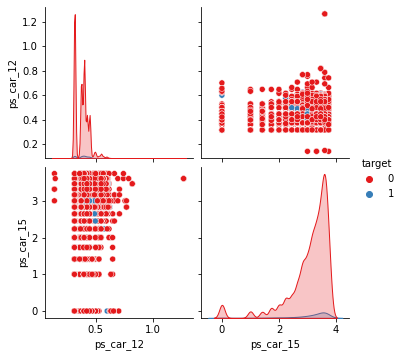

In [68]:
sample = trainset.sample(frac=0.05)
var = ['ps_car_12', 'ps_car_15', 'target']
sample = sample[var]
sns.pairplot(sample, hue='target', palette='Set1', diag_kind='kde')
plt.show()

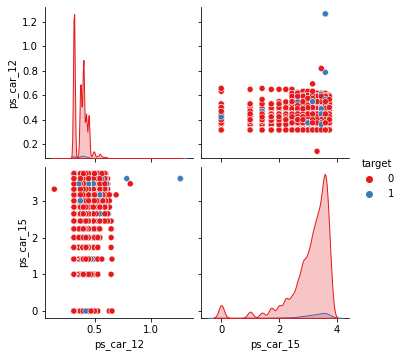

In [69]:
sample = trainset.sample(frac=0.05)
var = ['ps_car_12', 'ps_car_15', 'target']
sample = sample[var]
sns.pairplot(sample,  hue='target', palette = 'Set1', diag_kind='kde')
plt.show()

Calculated features  
`ps_cals_01, ps_calc_02, ps_calc_03`은 비슷한 분포 형태를 띄며 일종의 비율을 나타낸 것 같습니다. 이들의 maximum value 0.9이기 때문입니다. 다른 calculated values는 maximum value가 정수(integer)입니다. (5, 6, 7, 10, 12)  
  
이들은 실수이기 때문에 density plot을 통해 시각화를 해보겠습니다.

<Figure size 432x288 with 0 Axes>

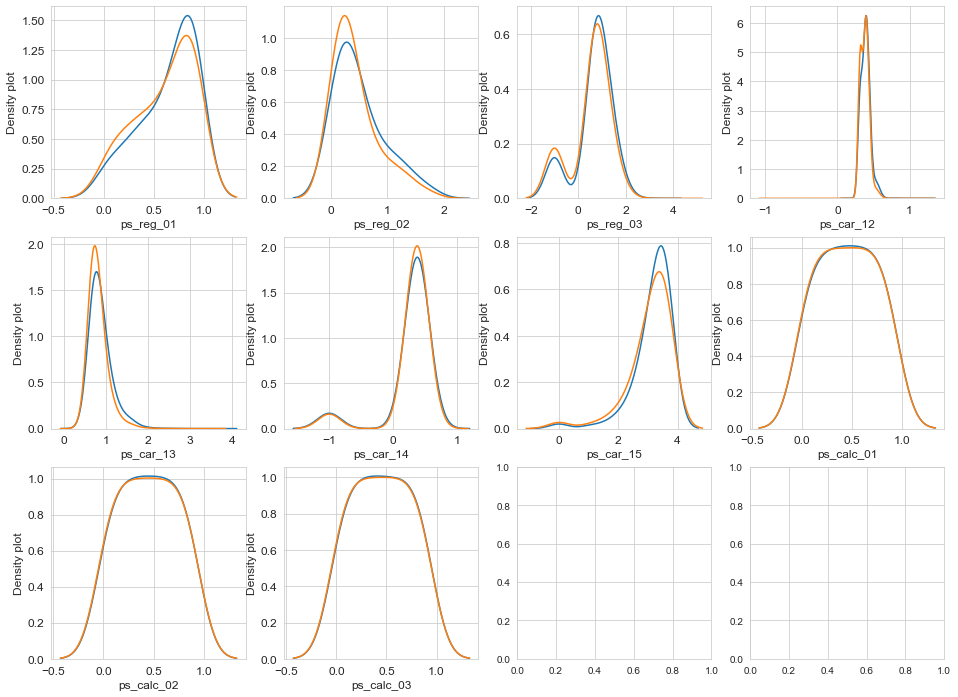

In [76]:
var = metadata[(metadata.type == 'real') & (metadata.preserve)].index
i = 0
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(3,4,figsize=(16,12))

for feature in var:
    i += 1
    plt.subplot(3,4,i)
    sns.kdeplot(t1[feature], bw_method=0.5,label="target=1") # 코드 수정. bw > bw_method. bw는 이제 사용되지 않는다고 함. soothing 해주는 기능.
    sns.kdeplot(t0[feature], bw_method=0.5,label="target=0")
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

`ps_reg_02, ps_car_13, ps_car_15`는 target=0, target=1이 연관된 set에 있어서 가장 다른 분포를 보여줍니다.  
  
실수 feature들의 상관관계에 대해서 시각화를 진행해 보겠습니다.